# Housing Data Analysis with Linear Regression

## Overview

For this project I'll be using the Kings County housing dataset to solve a housing-related business problem using linear regression techniques.
I'll be using the CRISP-DM Data Science method which the structure this notebook will follow.

<img src="Images/new_crisp-dm.png" width=400>

## Business Understanding

A housing development company is working on new model homes. They want to design houses that will sell to middle class buyers who are currently facing a shortage of available and affordable inventory due to the increase in demand during 2020.

The median national home listing price grew by 13.4% over last year nationally, and The Seattle-Tacoma-Bellevue metro area saw YoY listing prices rise 7.8% with a median price of $627,500. Meanwhile, there was a 35.6% decrease in listings. So less houses available and higher prices. 

The developers would like understand which features a home should include at the median price range so that they can appropriately desing new homes to boost inventory and make some sales.

https://www.realtor.com/research/december-2020-data/

## Data Understanding

This data includes house sale prices and conditions from houses sold through 2014-2015 in the Seattle area. These houses were built as early as 1900 and as late as 2015. 

https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

I'm going to start by importing *all* my libraries and loading the data into a dataframe

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [89]:
data = pd.read_csv('data/kc_house_data.csv')
data.info()
# data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


The median price in the dataset is $450K, so I'll have to define a range of the data I am using for my model. By examining the distribution of values, I can see there are a few outliers on the higher end that could skew my model.

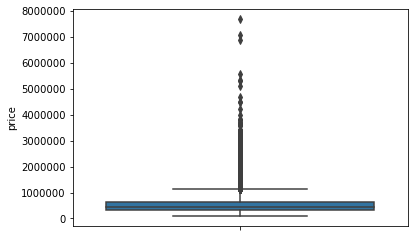

In [90]:
sns.boxplot(data['price'], orient='v')

In [91]:
data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [92]:
y_range = ((data['price'].std()*2) - data['price'].mean()), (data['price'].mean() + (data['price'].std()*2))
y_range

(194439.7066972095, 1275032.8537083685)

In [93]:
new_data = data[data['price'].between(y_range[0], y_range[1])]
new_data['price'].describe()

count    2.008300e+04
mean     4.986744e+05
std      2.198803e+05
min      1.948200e+05
25%      3.289750e+05
50%      4.500000e+05
75%      6.200000e+05
max      1.270000e+06
Name: price, dtype: float64

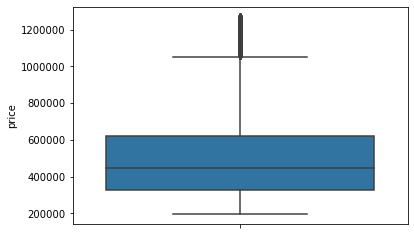

In [94]:
sns.boxplot(new_data['price'], orient='v')

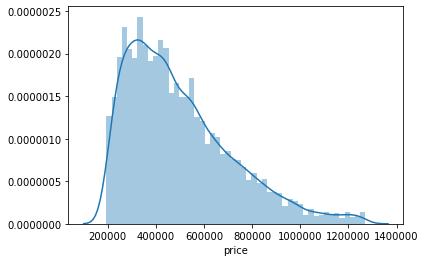

In [95]:
sns.distplot(new_data['price'])

In [96]:
(data.shape[0] - new_data.shape[0])/ data.shape[0]

0.07010232902717971

The new dataframe eliminated a lot of the outliers on the higher priced end that do not represent the type of houses we want to use for our model so that we are now looking at more affordable homes that aren't the lowest priced ones on the market either. Only 7% oof my original data was filtered out so I still have a lot to work with.

## Data Preparation

### Data Cleaning
Previewing the data I can see there are some null values I'll have to deal with. These are coming from year renovated, view, and waterfront. It also looks like sqft_basement is an object not at integer. On a closer look, many of the rows contain a '?'. I'm going to fill nulls and examine the data more closely.

For Waterfront and View:

 - There are only 146 houses that are coded as waterfront. I don't want to drop nulls because there are over 2K, so I am going to fill the null values with 0 since it won't affect the distribution much.
 - The view column has 63 null values. This column describes how many times a house has been viewed (not the views from the house), which I don't see as being really important as a feature because there are a lot of reasons it could/could not have been viewed a given number of times. I am going to fill these nulls with a 0 assuming they were not available to view.

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

In [97]:
new_data['waterfront'].fillna(0.0, inplace=True)
new_data['view'].fillna(0.0, inplace=True)

For year renovated, I am going to assume the nulls represent houses that were not renovated. I'm going to fill the nulls with 0, but also make a binary indicator column that just tells me whether the house was or was not renovated instead of what year. I'll keep both columns for now.

In [98]:
new_data['yr_renovated'].fillna(0.0, inplace=True)

#new column  
new_data['is_renovated'] = 0

# loop through the data and input a 1 where the house was renovated
for row in new_data.index:
    if new_data['yr_renovated'][row] != 0.0:
        new_data['is_renovated'][row] = 1

Lastly for squarefoot basement, I am going to replace all the '?' symbols with 0 to make this column readable, assuming these houses do not have basements.

In [99]:
new_data['sqft_basement'] = new_data['sqft_basement'].map(lambda x: x.replace("?", "0"))
new_data['sqft_basement'] = pd.to_numeric(new_data['sqft_basement'], downcast='integer')

After running a .describe and examining some columns, I see one outlier I want to remove because it looks incorrect - a house that has 33 bedrooms and 1.75 bath that costs only $640k.

In [100]:
new_data[new_data.bedrooms == new_data.bedrooms.max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0


In [101]:
new_data = new_data.drop([15856], axis=0)

### Preprocessing

Now I am going to examine the data to see how it will need to be processed to fit to a model. 

First I'm going to separate my continuous from categorical columns so I can treat each type appropriately. I am excluding ID, date and the sqft 15 columns for now. The dates are all from the same 2 years so there isn't a diverse amount of data - it basically just tells me that all these houses were sold. The neighboring house info is not relevant since my stakeholders are working on a new development for which they'll design neighboring houses.

I'm separating out latitude and longitude since they are technically continuous but can't be treated the same way as other continuous variables.

In [102]:
cat_cols= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'view', 'is_renovated', 'zipcode']
con_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
geo_cols= ['lat', 'long']
y = new_data['price']
X_cols = new_data[cat_cols + con_cols + geo_cols]

Then I'm going to run a few visual techniques to take a look at my data and see what features I may need to address for modeling. First, looking at the distributions.

In [103]:
# sns.pairplot(data[con_cols])
# sns.pairplot(data[cat_cols])

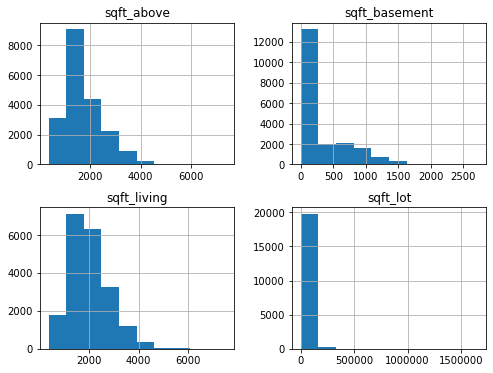

In [104]:
#running a histogram to examine the distribution of continuous columns
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
new_data[con_cols].hist(ax = ax);

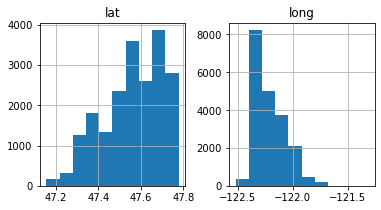

In [105]:
#running a histogram to examine the distribution of lat & long columns
fig = plt.figure(figsize = (6,3))
ax = fig.gca()
new_data[geo_cols].hist(ax = ax);

None of my continuous variables look normally distributed so I'm going to note that I'll probably need to go back and normalize them.

Now I want to look for potential multicollinearity. I'll use a heat map of all the columns.

(18, 0)

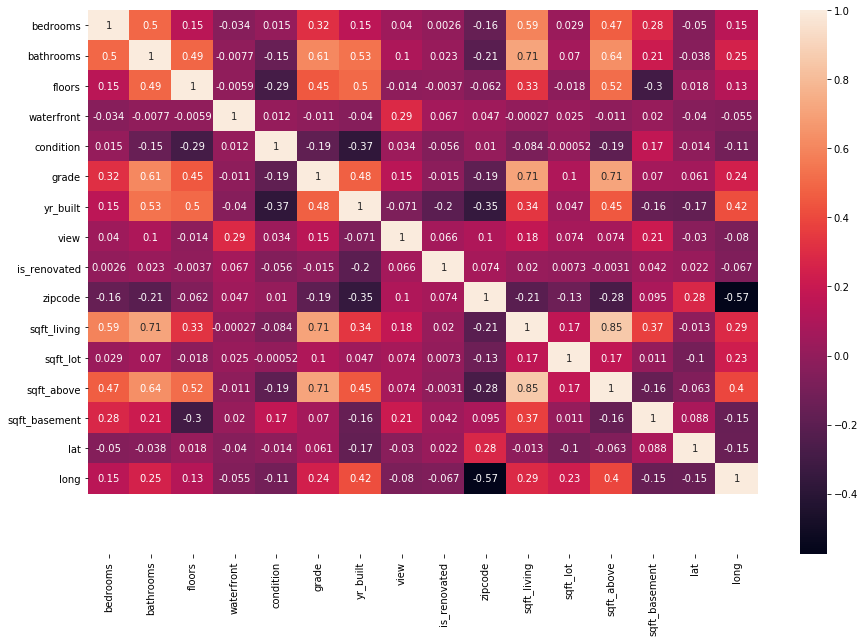

In [106]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(new_data[cat_cols + con_cols + geo_cols].corr(), annot=True)
ax.set_ylim(18,0)

I can see that some features have high correlations (above 0.75): Bathrooms + sqft, grade & sqft, sqft above and sqft living. I'll keep this in mind for feature engineering, but first I'm going to run a 'baseline' model.

## Modeling

### First 'Substandard' Model & Evaluation

Before I go into feature selection, I'll quickly run a basic model. Since CRISP-DM is an iterative process, I'll start with this and then circle back as many times as necessary to get the results I'm looking for.

I'm going to use a pretty standard train-test split of 70/30, scale my data, and fit it to a model. 

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_cols, y, test_size=0.3, random_state=20)

#using a standard scaler so I can interpret coefficients
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [108]:
#fitting my model
linreg = LinearRegression()
model = linreg.fit(X_train_scaled, y_train)

#obtaining predicted values for both train and test data
y_hat_train = linreg.predict(X_train_scaled)
y_hat_test = linreg.predict(X_test_scaled)

In [109]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [110]:
# print(f'Train Mean Squarred Error: {mean_squared_error(y_train, y_hat_train)}')
# print(f'Test Mean Squarred Error: {mean_squared_error(y_test, y_hat_test)}')
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 122837.63091490367
Test Root Mean Squarred Error: 125967.3763622895
Train R2: 0.6876858606110025
Test R2: 0.6723032537279783


So, my R2 score actually isn't terrible. The test R2 is slightly under the train, which suggests that my model may be slightly overfit. 

However, there is a lot of error, so my model is not very accurate. 

Circling back to the Data Preparation stage, I want to make some transformations on columns that do not fit the assumptions for linear regression. I'll start with transforming the continuous variables, since all look non-normal, and then address the multicollinearity.

Before I move on, I want to take a quick look at the coefficients so I don't remove anything that may be important.

In [111]:
#getting my coefficients and formmating them into a readable, sorted dataframe

coefficients = linreg.coef_
# coefficients = abs(coefficients)
coef_dict = dict(list(zip(X_cols.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
grade,778876.184426
sqft_living,399611.711866
lat,343577.577351
sqft_lot,241420.210936
sqft_above,222729.643726
waterfront,192530.289940
bathrooms,158302.584709
view,147849.423489
condition,91642.265112
sqft_basement,89868.808210


At a first glance, all the features show influence over the target but some much more so than others. I may remove some that are redundant (i.e. there are many different indicators of the size of the house).

## Back to Data Preparation

My next step is to normalize continuous columns. I am going to log transform th continuous set, but that's not going to work for my geo columns because they have negative values. For those, I'll set up a function to 'normalize'. 

In [112]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

con_cols_norm = new_data[con_cols].apply(normalize)
geo_cols_norm = new_data[geo_cols].apply(normalize)

In [113]:
new_X = pd.concat([geo_cols_norm, con_cols_norm, new_data[cat_cols]], axis=1)

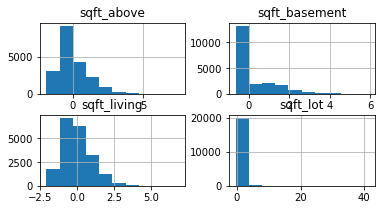

In [114]:
fig = plt.figure(figsize = (6,3))
ax = fig.gca()
con_cols_norm.hist(ax = ax);

These look slightly better. Note that I also tried to log transform these columns but I saw worse results from my model.

Now to examine multicollinearity.

First I want to address the sqft columns since they will have overlapping info:

* **sqft_living** -  footage of the home
* **sqft_lot** -  footage of the lot
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement

Looking at the coefficients, sqft_living has high correlation with sqft_above. This makes sense, because sqft_living = sqft_above + sqft_basement, and not all houses have basements. 

Since sqft_living had one of the highest coefficients in my baseline model, I'm going to drop sqft_above so that we are factoring in the total sqft of the house, and the total sqft of the lot. I am going to remove the sqft_basement column and add a binary indicator, has_basement, since the total area will be captured in sqft_living.

In [115]:
new_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639,1
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503,0
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,3890,1530,2001,0.0,98053,47.6561,-122.005,4760,101930,0


In [116]:
con_cols_norm = con_cols_norm.drop(['sqft_above'], axis=1)

In [117]:
#new column  
new_data['has_basement'] = 0

# loop through the data and input a 1 where there is a basement
for row in new_data.index:
    if new_data['sqft_basement'][row] != 0:
        new_data['has_basement'][row] = 1

In [118]:
con_cols_norm = con_cols_norm.drop(['sqft_basement'], axis=1)

In [121]:
new_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0,1955,0.0,98178,47.5112,-122.257,1340,5650,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,400,1951,1991.0,98125,47.7210,-122.319,1690,7639,1,1
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,910,1965,0.0,98136,47.5208,-122.393,1360,5000,0,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0,1987,0.0,98074,47.6168,-122.045,1800,7503,0,0
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,1530,2001,0.0,98053,47.6561,-122.005,4760,101930,0,1


In [122]:
cat_cols_new = pd.concat([new_data[cat_cols], new_data['has_basement']], axis=1)

In [123]:
cat_cols_new.head()

,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,view,is_renovated,zipcode,has_basement
0,3,1.00,1.0,0.0,3,7,1955,0.0,0,98178,0
1,3,2.25,2.0,0.0,3,7,1951,0.0,1,98125,1
3,4,3.00,1.0,0.0,5,7,1965,0.0,0,98136,1
4,3,2.00,1.0,0.0,3,8,1987,0.0,0,98074,0
5,4,4.50,1.0,0.0,3,11,2001,0.0,0,98053,1


In [125]:
new_X = pd.concat([geo_cols_norm, con_cols_norm, cat_cols_new], axis=1)

In [127]:
new_X.corr() > 0.75

,lat,long,sqft_living,sqft_lot,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,view,is_renovated,zipcode,has_basement
lat,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
long,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


So that gets rid of high multicollinearity. I'm going to run the model again to see if it's improved. 

In [129]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=20)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_2 = scaler.transform(X_train)
X_test_scaled_2 = scaler.transform(X_test)
linreg = LinearRegression()
model2 = linreg.fit(X_train_scaled_2, y_train)

In [130]:
y_hat_train = linreg.predict(X_train_scaled_2)
y_hat_test = linreg.predict(X_test_scaled_2)

In [131]:
print(f'Train Mean Squarred Error: {mean_squared_error(y_train, y_hat_train)}')
print(f'Test Mean Squarred Error: {mean_squared_error(y_test, y_hat_test)}')
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Mean Squarred Error: 15091881835.954483
Test Mean Squarred Error: 15887542650.59098
Train Root Mean Squarred Error: 122849.02049245033
Test Root Mean Squarred Error: 126045.79584655324
Train R2: 0.6876279420238006
Test R2: 0.6718951193441076


My error decreased very slightly but R2 scores didn't increase. I still have some categoricals to deal with. Zipcode and lat/long are both indicators of location so I want to examine these a little closer and see if I can make them more useful. 

In [132]:
new_X.head()

,lat,long,sqft_living,sqft_lot,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,view,is_renovated,zipcode,has_basement
0,-0.366664,-0.314142,-1.070629,-0.229604,3,1.00,1.0,0.0,3,7,1955,0.0,0,98178,0
1,1.140764,-0.751931,0.683773,-0.189625,3,2.25,2.0,0.0,3,7,1951,0.0,1,98125,1
3,-0.297687,-1.274453,-0.086144,-0.245927,4,3.00,1.0,0.0,5,7,1965,0.0,0,98136,1
4,0.392080,1.182813,-0.439549,-0.168581,3,2.00,1.0,0.0,3,8,1987,0.0,0,98074,0
5,0.674453,1.465257,4.280928,2.188212,4,4.50,1.0,0.0,3,11,2001,0.0,0,98053,1


In [148]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = new_data['long'], lat = new_data['lat'],
        mode = 'markers'
        ))

fig.update_layout(
        title = 'Houses lat long',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True
        ))

# focus point
lat_foc = new_data['lat'].median()
lon_foc = new_data['long'].median()
fig.update_layout(
        geo = dict(
            projection_scale=24, #this is kind of like zoom
            center=dict(lat=lat_foc, lon=lon_foc), # this will center on the point
        ))

fig.show()

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
